In [1]:
import sqlite3
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

In [2]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [3]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [4]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [5]:
import pandas as pd
connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [6]:
connection = sqlite3.connect('data.db')
query = """
        select *
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [7]:
my_database_file_path = "/content/data.db"

In [8]:
print(client.head(10))
print(client_products.head(10))
print(balances.head(10))
print(inv_campaign_eval.head(10))
print(clients_merged.head(10))

    client_id   age            job   marital  education gender
0   249789938  38.0       services   married  secondary      M
1  1222646323  46.0       services  divorced    unknown      M
2   451375919  33.0         admin.    single  secondary      F
3   338972671  44.0  self-employed   married  secondary      F
4  1472834688  36.0    blue-collar   married    primary      M
5  1068680340  63.0         admin.   married  secondary      F
6   711558356  38.0  self-employed    single   tertiary      F
7   422084751  30.0     technician    single  secondary      M
8   123316323  36.0    blue-collar  divorced  secondary      F
9  1504633819  38.0     management   married   tertiary      M
    client_id has_deposits loan has_insurance has_mortgage
0   249789938          yes   no             n           no
1  1222646323           no   no             n           no
2   451375919           no   no             n          yes
3   338972671           no   no             y          yes
4  147283468

In [13]:
# Corrected filter
filter_condition = (clients_merged["poutcome"] == 'failure')

# Add a new column "has_family" and initialize it to 0
clients_merged["success"] = 1

# Set "has_family" to 1 where the filter condition is met
clients_merged.loc[filter_condition, "success"] = 0

# Display the DataFrame
print(clients_merged.head())

    client_id   age            job   marital  education gender   client_id  \
0   249789938  38.0       services   married  secondary      M   249789938   
1  1222646323  46.0       services  divorced    unknown      M  1222646323   
2   451375919  33.0         admin.    single  secondary      F   451375919   
3   338972671  44.0  self-employed   married  secondary      F   338972671   
4  1472834688  36.0    blue-collar   married    primary      M  1472834688   

  has_deposits loan has_insurance has_mortgage    client_id poutcome  success  
0          yes   no             n           no  249789938.0  success        1  
1           no   no             n           no          NaN     None        1  
2           no   no             n          yes          NaN     None        1  
3           no   no             y          yes          NaN     None        1  
4          yes   no             n          yes          NaN     None        1  


In [10]:
clients_merged.isnull().sum()

client_id           0
age               232
job               438
marital             0
education           0
gender              0
client_id           0
has_deposits        0
loan                0
has_insurance       0
has_mortgage        0
client_id        8863
poutcome         8863
success             0
dtype: int64

In [11]:
clients_merged.dtypes

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
client_id          int64
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
client_id        float64
poutcome          object
success            int64
dtype: object

ValueError: Could not interpret value `success` for `x`. An entry with this name does not appear in `data`.

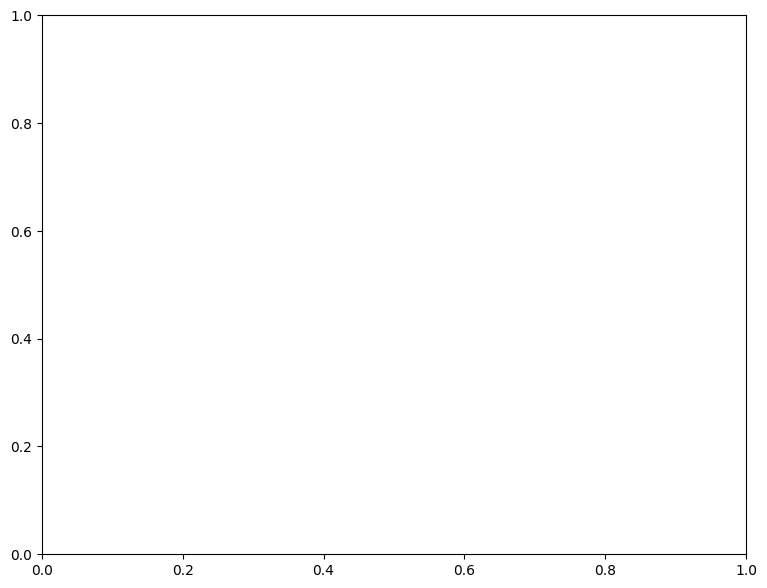

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 7))

# Survival rate by Sex
plt.subplot(1, 2, 1)
sns.countplot(data=inv_campaign_eval, x='success', palette='viridis')
plt.title('Survival Rate by Sex')

In [23]:
client['job'].fillna('unknown', inplace=True)

# Display the updated DataFrame
print(client.head())

    client_id   age            job   marital  education gender
0   249789938  38.0       services   married  secondary      M
1  1222646323  46.0       services  divorced    unknown      M
2   451375919  33.0         admin.    single  secondary      F
3   338972671  44.0  self-employed   married  secondary      F
4  1472834688  36.0    blue-collar   married    primary      M


In [15]:
client.isnull().sum()

client_id      0
age          232
job            0
marital        0
education      0
gender         0
dtype: int64

In [20]:
connection = sqlite3.connect('data.db')
query = """
        select *
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id;
        """
client_and_products = pd.read_sql_query(query, connection)
connection.close

client_and_products = client_and_products.T.drop_duplicates().T
client_and_products.head()
client_and_products.dtypes


client_id        object
age              object
job              object
marital          object
education        object
gender           object
has_deposits     object
loan             object
has_insurance    object
has_mortgage     object
dtype: object

In [ ]:
connection = sqlite3.connect('data.db')
query = """
        select *
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id;
        """
client_and_products = pd.read_sql_query(query, connection)
connection.close

client_and_products = client_and_products.T.drop_duplicates().T
client_and_products.head()
client_and_products.dtypes

In [22]:
# Assuming df is your DataFrame with columns 'client_id' and 'timestamp'
# Make sure 'timestamp' is in datetime format
balances['date'] = pd.to_datetime(balances['date'])

# Get the index of the last timestamp for each client_id
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()

# Use the index to extract the corresponding rows from the original DataFrame
last_timestamp_df = balances.loc[last_timestamp_index]

# Display the DataFrame with the last timestamp for each client_id
print(last_timestamp_df)

                             date      balance   client_id currency
265876 2023-06-06 16:22:36.643827   175.445269   100070076      CZK
175292 2023-06-06 16:22:04.265177  2559.041192   100141910      CZK
191620 2023-06-06 16:22:09.249972    94.055761   100207570      CZK
43680  2023-06-06 16:21:25.597087   382.755389   100488560      CZK
262678 2023-06-06 16:22:35.410449   369.476219   100605013      CZK
...                           ...          ...         ...      ...
22854  2023-06-06 16:21:20.742835  1146.101785  1999463182      CZK
130338 2023-06-06 16:21:50.781726    30.830676  1999499145      CZK
87074  2023-06-06 16:21:36.964752   792.767525  1999715381      CZK
89154  2023-06-06 16:21:37.470159  5077.753230  1999945413      CZK
232674 2023-06-06 16:22:24.006798   229.440915  1999956516      CZK

[11162 rows x 4 columns]
